In [17]:
import numpy as np
from astropy.modeling.models import Sersic1D, Sersic2D
from astropy.modeling.core import Fittable1DModel, Parameter
import matplotlib.pyplot as plt
from astropy.visualization import hist
from scipy.stats import rv_continuous
import timeit
from scipy.integrate import cumtrapz

In [2]:
def randomvariate(pdf, n, xmin, xmax):
    """
    Create random numbers according to an arbitrary PDF
    Uses the rejection method for generating random numbers derived from an arbitrary   
    probability distribution. For reference, see Bevington's book, page 84. Based on  
    rejection*.py.
    Usage:  
    >>> randomvariate(P,N,xmin,xmax)  
    where  
    P : probability distribution function from which you want to generate random numbers  
    N : desired number of random values  
    xmin,xmax : range of random numbers desired  
    
    Returns:   
    the sequence (ran,ntrials) where  
    ran : array of shape N with the random variates that follow the input P  
    ntrials : number of trials the code needed to achieve N  
   
    Here is the algorithm:  
    - generate x' in the desired range  
    - generate y' between Pmin and Pmax (Pmax is the maximal value of your pdf)  
    - if y'<P(x') accept x', otherwise reject  
    - repeat until desired number is achieved  
   
    Rodrigo Nemmen  
    Nov. 2011  
    """
    x = np.linspace(xmin, xmax, 10000)
    y = pdf(x)
    pmin = y.min()
    pmax = y.max()
    naccept = 0
    ntrial = 0
    ran = []
    while naccept < n:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(pmin, pmax)
        if y <= pdf(x):
            ran.append(x)
            naccept = naccept+1
                #  print pdf(x)
            ntrial = ntrial + 1

    ran = np.asarray(ran)
    return ran, ntrial
    

In [66]:
def rvs(pdf, n, xmin, xmax, grid=1000):
    """
    try it with numpy
    """
    
    x = np.linspace(xmin, xmax, grid)
    y = pdf(x)
    pmin = y.min()
    pmax = y.max()
   
    rel_area =  (xmax -xmin)*(pmax - pmin) / np.trapz(y, x)
    m = int(n * rel_area) * 2
    ran = np.array([])
    
    
    while ran.size < n:
        
        X = np.random.uniform(xmin, xmax, m)
        Y = np.random.uniform(pmin, pmax, m)
        ran = np.append(ran, X[Y<=pdf(X)])  # the evaluation pdf(X) is the slow part
       
    return ran[:n]

In [4]:
class Sersic1D(Fittable1DModel):
    amplitude = Parameter(default=1)
    r_eff = Parameter(default=1)
    n = Parameter(default=4)
    _gammaincinv = None

    @classmethod
    def evaluate(cls, r, amplitude, r_eff, n):
        """One dimensional Sersic profile function."""

        if cls._gammaincinv is None:
            try:
                from scipy.special import gammaincinv
                cls._gammaincinv = gammaincinv
            except ValueError:
                raise ImportError('Sersic1D model requires scipy > 0.11.')

        return (amplitude * np.exp(
            -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))
    
    def _pdf(self, r):
        s = Sersic1D(amplitude=self.amplitude, r_eff=self.r_eff, n=self.n)
        return s(r)


In [5]:
def gauss_pdf(x):
    return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)

TIME randomvariate:  13.180728734005243
4746940
0
TIME rvs with numpy:  0.18479363899677992
1000000 1000000


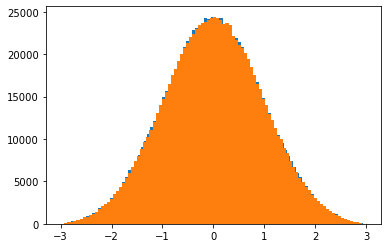

In [51]:
N = 1000000
xmin = -3
xmax = -1*xmin

start_time = timeit.default_timer()

x_rvariate, ntrial = randomvariate(gauss_pdf, N, xmin=xmin, xmax=xmax)

print("TIME randomvariate: ", timeit.default_timer() - start_time)

start_time = timeit.default_timer()

x_rvs = rvs(gauss_pdf, N, xmin=xmax, xmax=xmin)

print("TIME rvs with numpy: ", timeit.default_timer() - start_time)


hist(x_rvariate, bins=100)
hist(x_rvs, bins=100)
print(x_rvariate.size, x_rvs.size)

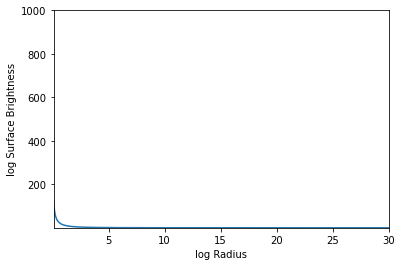

In [7]:
plt.figure()
plt.subplot(111) #, xscale='log', yscale='log')
s1 = Sersic1D(amplitude=1, r_eff=5, n=4)
r=np.arange(0, 100, .01)

plt.plot(r, s1(r))

plt.axis([1e-1, 30, 1e-2, 1e3])
plt.xlabel('log Radius')
plt.ylabel('log Surface Brightness')
#plt.text(.25, 1.5, 'n=1')
#plt.text(.25, 300, 'n=10')
#plt.xticks([])
#plt.yticks([])
plt.show()

sersic = Sersic1D(amplitude=1, r_eff=5, n=4)

TIME randomvariate:  1971.2118817280007
TIME rvs with numpy:  4.64048584900047
1000000 100000


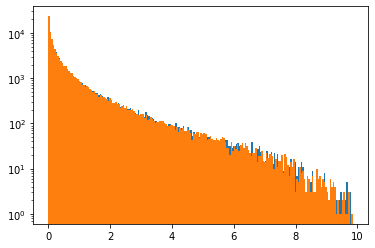

In [39]:


N = 1000
xmin = 0
xmax = 10


start_time = timeit.default_timer()
x_ran, ntrial = randomvariate(sersic, N, xmin=xmin, xmax=xmax)

print("TIME randomvariate: ", timeit.default_timer() - start_time)

start_time = timeit.default_timer()
x_rvs = rvs(sersic, N, xmin=xmin, xmax=xmax)
print("TIME rvs with numpy: ", timeit.default_timer() - start_time)


hist(x_ran, bins=200)
hist(x_rvs, bins=200)
print(x_rvan.size, x_rvs.size)
plt.semilogy()
plt.show()

In [110]:
N = int(1e5)
xmin = 0
xmax = 50
start_time = timeit.default_timer()
x_rvs = rvs(sersic, N, xmin=xmin, xmax=xmax)
print("TIME rvs with numpy: ", timeit.default_timer() - start_time)

print(x_rvs.size)


TIME rvs with numpy:  13.725462265996612
100000


292.0953538120333
(1000,)


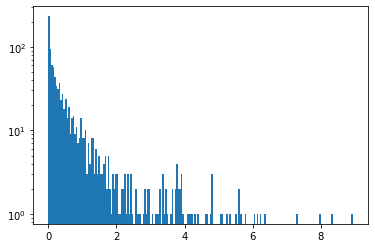

In [39]:
ran = rvs(s1, 1000, xmin=0, xmax=10)
print(ran.shape)
hist(ran, bins=200)
plt.semilogy()
plt.show()

------

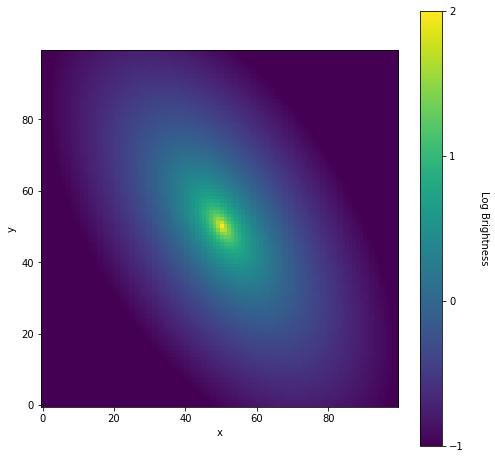

In [24]:
x,y = np.meshgrid(np.arange(100), np.arange(100))

mod = Sersic2D(amplitude = 1, r_eff = 25, n=4, x_0=50, y_0=50,
               ellip=.5, theta=-1)
img = mod(x, y)
log_img = np.log10(img)

plt.figure(figsize=(8,8))
plt.imshow(log_img, origin='lower', interpolation='nearest',
           vmin=-1, vmax=2)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [98]:
def uniform_proposal(x, delta=2.0):
    return np.random.uniform(x - delta, x + delta)


def metropolis_sampler(p, nsamples, proposal=uniform_proposal):
    """
    Taken from Here 
    https://stackoverflow.com/questions/51050658/how-to-generate-random-numbers-with-predefined-probability-distribution


    Usage
    s1 = Sersic1D(amplitude=1, r_eff=5, n=4)

    p = lambda r: s1(r)

    samples = list(metropolis_sampler(p, N))

    """


    x = 1 # start somewhere

    for i in range(nsamples):
        trial = proposal(x) # random neighbour from the proposal distribution
        acceptance = p(trial)/p(x)

        # accept the move conditionally
        if np.random.uniform() < acceptance:
            x = trial

        yield x



In [99]:
N = int(1e5)
xmin = 0
xmax = 10
start_time = timeit.default_timer()

p = lambda r: sersic(r)

samples = list(metropolis_sampler(p, N))
print("TIME with metropolis: ", timeit.default_timer() - start_time)



<ipython-input-4-d2913174b899>:19: RuntimeWarning: invalid value encountered in power
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))


TIME with metropolis:  12.289208931004396


100000 100000


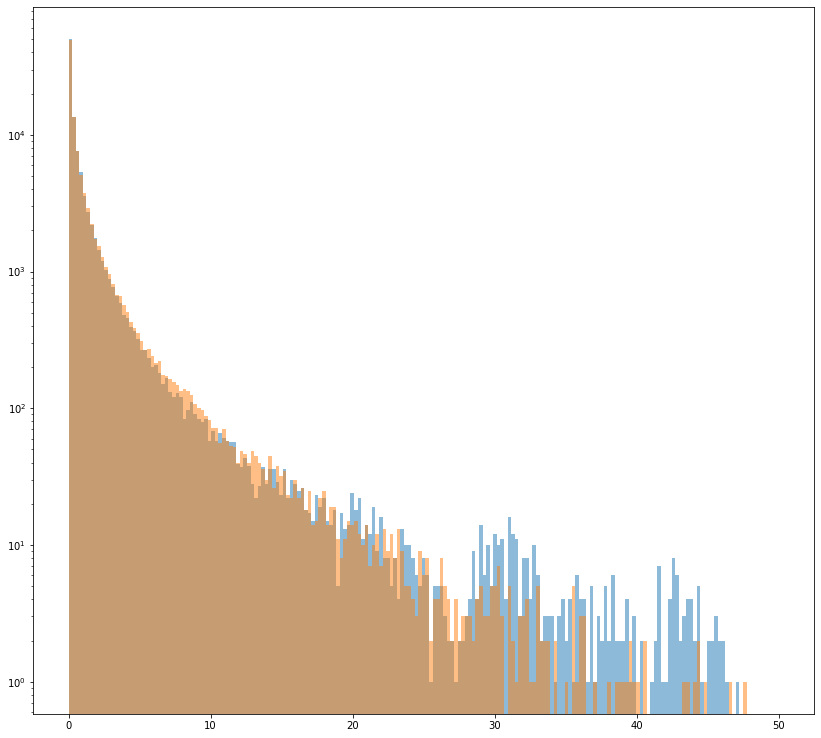

In [112]:
print(len(samples), x_rvs.size)
fig = plt.figure(figsize=(14,13))

bins = np.linspace(0,50, 200)
hist(samples, bins=bins, alpha=0.5)
hist(x_rvs, bins=bins, alpha=0.5)
plt.semilogy()
plt.show()

In [97]:
samples

[0.46574672869420963,
 0.46574672869420963,
 0.46574672869420963,
 0.46574672869420963,
 0.46574672869420963,
 0.46574672869420963,
 0.45286314936118366,
 0.37495083447233846,
 0.7606430680680489,
 0.7606430680680489,
 0.7606430680680489,
 0.7606430680680489,
 0.7606430680680489,
 1.4019339425657646,
 1.4019339425657646,
 1.6983863369013825,
 0.8841714021646023,
 0.6944731230430263,
 0.6944731230430263,
 1.8642064605429103,
 2.4908048036969603,
 2.4908048036969603,
 1.4217564874672868,
 1.2759245634769658,
 1.1307835654888132,
 0.14962300622430735,
 0.14962300622430735,
 0.14962300622430735,
 0.14962300622430735,
 0.14962300622430735,
 2.0185671267150562,
 1.098464911546301,
 1.2632188032595417,
 1.2632188032595417,
 1.191240007814561,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 0.2827980040359095,
 1.746743656902615,
 0.8892367036514002,
 0.8892367036514002,
 0.